# Taller 5. GWAS-Mapeo por asociación para un rasgo complejo de interés
Genética de rasgos complejos 2024-01 - Universidad Nacional de Colombia<br>
Docente Johana Carolina Soto Sedano - jcsotos@unal.edu.co
 
__Hans D. Escobar H.__ ([hdescobarh](https://github.com/hdescobarh))

In [197]:
# Configuración
options(digits = 3, repr.plot.width = 9, repr.plot.height = 7)

# Validaciones

results_directory <- "../Results/ncomponents_3"
if (!dir.exists(results_directory)) {
  stop("Results directory does not exist.", call. = FALSE)
}

phenotypes <- c("Cyanidin", "Delphinidin")
missing <- character()
results_paths <- character()
for (p in phenotypes) {
  current_file <- sprintf(
    "%s/GAPIT.Association.GWAS_Results.MLM.%s.csv",
    results_directory, p
  )
  if (file.exists(current_file)) {
    results_paths <- append(results_paths, current_file)
  } else {
    missing <- append(missing, p)
  }
}

if (length(missing) > 0) {
  stop(
    paste(
      "Did not found the following phenotypes: ",
      paste(missing, collapse = ", ")
    ),
    call. = FALSE
  )
} else {
  names(results_paths) <- phenotypes
}


## SNPs significativamente asociados


In [198]:
obtener_significativos <- function(
    results_file, p_value_threshold = 0.05, fdr_threshold = 0.05) {
  df <- read.csv(
    results_file,
    row.names = 1
  )
  df <- df[
    df$P.value < p_value_threshold & df$H.B.P.Value < fdr_threshold,
  ]
  df[order(df$P.value), ]
  df <- subset(df, select = -c(4:5, 7))
  df
}
significativos <- lapply(results_paths, obtener_significativos)


In [199]:
# Encontrar tablas con información del la varianza fenotípica explicada
pve_files <- list.files(results_directory, "*PVE.MLM*")
pve_files


[1] "GAPIT.Association.PVE.MLM.Cyanidin.csv"

In [200]:
# Solo Cianidina tiene PVE, extraerlo y anexarlo
significativos$Cyanidin <- merge(
  significativos$Cyanidin,
  subset(read.csv(
    paste(results_directory, "/", pve_files[[1]], sep = ""),
    row.names = 1
  ), select = c("Phenotype_Variance_Explained...")),
  by = "row.names"
)
rownames(significativos$Cyanidin) <- significativos$Cyanidin$Row.names
significativos$Cyanidin <- subset(significativos$Cyanidin, select = -c(1))
colnames(significativos$Cyanidin)[
  which(
    names(significativos$Cyanidin) == "Phenotype_Variance_Explained..."
  )
] <- "PVE"


### Cianidina

In [201]:
cat("Tabla 1. SNPs con asociación significativa - Cianidina")
significativos$Cyanidin


Tabla 1. SNPs con asociación significativa - Cianidina

,Chr,Pos,P.value,H.B.P.Value,PVE
,<chr>,<int>,<dbl>,<dbl>,<dbl>
SNP54914,ST4.03ch08,20571240,4.59e-08,0.00384,14.84
SNP83234,ST4.03ch12,59154862,3.12e-07,0.00809,68.94
SNP9317,ST4.03ch01,76112400,3.86e-07,0.00809,3.12
SNP9318,ST4.03ch01,76112450,3.86e-07,0.00809,2.32


Para Cianidina se encontraron cuatro SNPs con asociación significativa: dos de ellos en el cromosoma 1 a 50pb de distancia, uno en cromosoma 8, y otro en el 12 (Fig. 1 y Tabla 1). Notablemente, el marcador 83234 por sí solo explica cerca del 70% de la varianza fenotípica (Tabla 1). </br>

![GWAS_Manhattan_Cyanidin](../Results/ncomponents_3/GAPIT.Association.Manhattan_Geno.MLM.Cyanidin_1.png)</br>
__Figura 1. Manhattan Plot Cianidina__

### Delfinidina

In [202]:
cat("Tabla 2. SNPs con asociación significativa - Delfinidina")
significativos$Delphinidin


Tabla 2. SNPs con asociación significativa - Delfinidina

,Chr,Pos,P.value,H.B.P.Value
,<chr>,<int>,<dbl>,<dbl>
SNP12429,ST4.03ch02,7161936,2.91e-06,0.0489
SNP12430,ST4.03ch02,7161938,2.91e-06,0.0489
SNP12431,ST4.03ch02,7161942,2.91e-06,0.0489
SNP12432,ST4.03ch02,7161962,2.91e-06,0.0489
SNP12433,ST4.03ch02,7162010,2.91e-06,0.0489


In [203]:
distances <- numeric()
for (marker in rownames(significativos$Delphinidin)) {
  min_distance <- min(
    abs(
      significativos$Delphinidin[
        which(rownames(significativos$Delphinidin) != marker), "Pos"
      ] - significativos$Delphinidin[marker, "Pos"]
    )
  )
  distances <- append(distances, min_distance)
}

cat(
  "Ancho bloque: ",
  max(significativos$Delphinidin$Pos) - min(significativos$Delphinidin$Pos),
  "pb",
  "\nDistancia Euclidea media al vecino mas cercano: ",
  mean(distances), "pb",
  sep = ""
)


Ancho bloque: 74pb
Distancia Euclidea media al vecino mas cercano: 15.2pb

Según el criterio empleado por GAPIT, para Delfinidina no hubo marcadores con asociaciones significativas (Fig. 2); en contraste, considerando un FDR < 0.05 (Benjamini & Hochberg, 1995), sí hay 5 SNPs significativos (Tabla 2).

Es importante notar que el FDR está cerca al umbral. Los 5 marcadores identificados están en el mismo cromosoma y __contiguos__, formando un bloque de 74pb con distancia euclídea media entre marcadores de 15pb. El decaimiento de DL es entorno a 100pb y el DL promedio es alto (Fig. 6), además el QQ plot sugiere algo de estratificación en los datos (Fig. 4), lo cual aumenta la aparición de asociaciones espurias (Price et al., 2010). Por lo tanto, estos marcadores para DElfinidina deben tomarse con bastante prudencia.

![GWAS_Manhattan_Delphinidin](../Results/ncomponents_3/GAPIT.Association.Manhattan_Geno.MLM.Delphinidin_1.png)</br>
__Figura 2. Manhattan Plot Delfinidina__

## Ajuste del modelo

El modelo para Cianidina, pese a una anomalía en la mitad, en general muestra un buen ajuste con algunos pocos SNPs significativamente asociados (Fig. 3). En contraste, en el modelo de Delfinidina observamos que tempranamente varios puntos se desajustan (Fig. 4), sugiriendo un ligero grado de estructura en los datos. Como la estructura por parentesco cercano es pequeña(Fig. 7), puede valer la pena  explorar otras fuentes; por ejemplo, en esté análisis no se evaluaron relaciones de parentesco crípticas y la ancestría genética, las cuales también pueden causar estratificación de los datos (Price et al., 2010).

![QQ_plot_Cyanidin](../Results/ncomponents_3/GAPIT.Association.QQ.MLM.Cyanidin_1.png)</br>
__Figura 3. QQ Plot Cianidina__

![QQ_plot_Delphinidin](../Results/ncomponents_3/GAPIT.Association.QQ.MLM.Delphinidin_1.png)</br>
__Figura 4. QQ Plot Delfinidina__

## Desequilibrio de ligamiento y kinship 

Llama la atención la proporción de marcadores con un alto desequilibrio de ligamiento representados por los dos picos en los extremos (Fig. 5b); este comportamiento ocurre en todos los cromosomas (Fig. 5a). Los datos son densos, la mayoría de marcadores están a distancias iguales o menores de 10pb (Tabla 3).

El decaimiento del desequilibrio de ligamiento es corto, de apenas entorno a 1kb (Fig. 5f y 6), por lo que combinado con la densidad de marcadores ofrece una buena resolución para buscar genes candidatos entorno a los SNPs significativos.

In [205]:
ld <- read.csv(
  paste(
    results_directory, "/GAPIT.Genotype.Distance.Rsquare.csv",
    sep = ""
  ),
  row.names = 1
)
cat("Tabla 3. Distancias en pb y r² top 3 mas frecuentes:")
head(ld[order(ld$Number, decreasing = TRUE), ], n = 3)


Tabla 3. Distancias en pb y r² top 3 mas frecuentes:

,Distance,Rsquare,Number
,<dbl>,<dbl>,<int>
1,10,0.502,3590
2,20,0.441,1350
3,30,0.444,727


![DL](../Results/ncomponents_3/GAPIT.Genotype.Distance_R_Chro_1.png)</br>
__Figura 5. Decaimiento de desequilibrio de ligamiento__

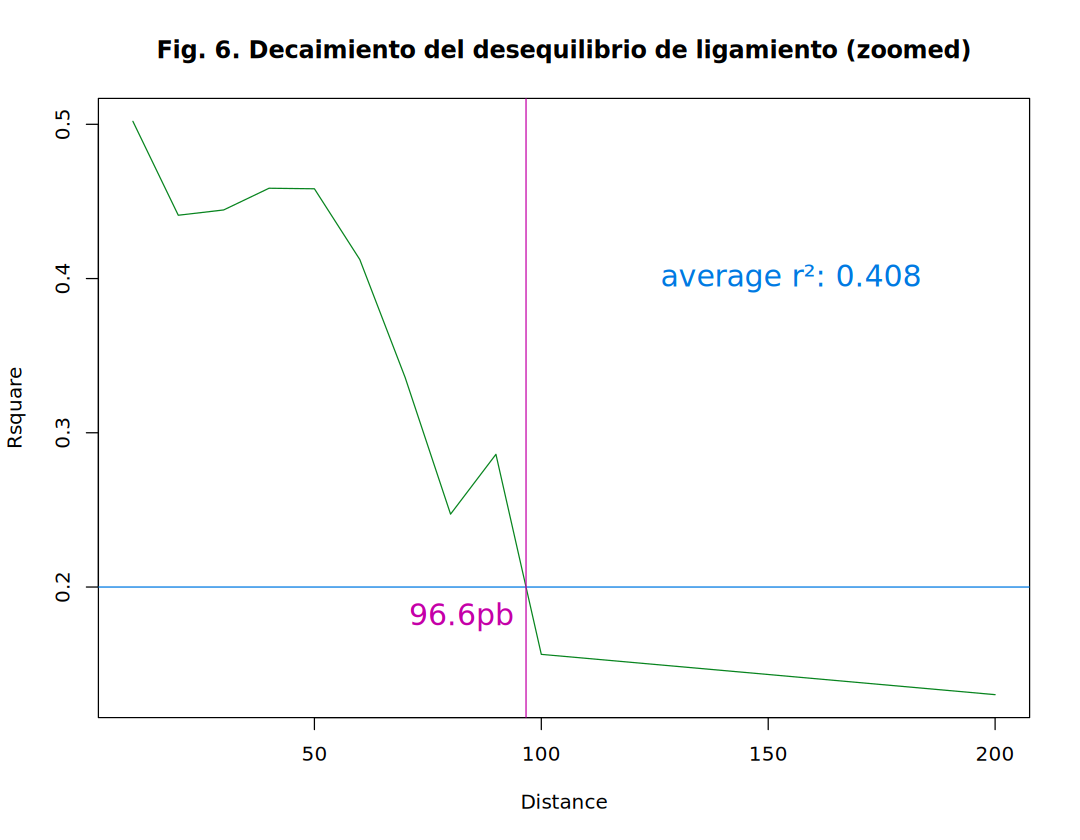

In [218]:
plot(
  ld[1:11, c("Distance", "Rsquare")],
  main = "Fig. 6. Decaimiento del desequilibrio de ligamiento (zoomed)",
  type = "l", col = "#07841e"
)
abline(h = 0.2, col = "#0079e2")

fitted <- lm(
  ld[c("9", "10"), "Rsquare"] ~ ld[c("9", "10"), "Distance"]
)
vertical_line <- (0.2 - fitted$coefficients[1]) / fitted$coefficients[2]
abline(v = vertical_line, col = "#c400a7")
text(
  x = vertical_line, y = 0.18,
  labels = sprintf("%.1fpb", vertical_line),
  pos = 2, col = "#c400a7", cex = 1.5
)

average_rsquare <- sum(ld$Rsquare * ld$Number) / sum(ld$Number)
text(
  x = 155, y = 0.4,
  labels = sprintf("r² promedio: %.3f", average_rsquare),
  col = "#0079e2", cex = 1.5
)


Hay algunos clusters pequeños de individuos cercanos; sin embargo, como se observa en el histograma, hay bajo parentesco entre los individuos (Fig. 7).

![Kinship](../Results/ncomponents_3/GAPIT.Genotype.Kin_Zhang_1.png)</br>
__Figura 7. Mapa de calor Kinship__


## Bibliografía

Benjamini, Y., & Hochberg, Y. (1995). Controlling the False Discovery Rate: A Practical and Powerful Approach to Multiple Testing. Journal of the Royal Statistical Society Series B: Statistical Methodology, 57(1), 289–300. https://doi.org/10.1111/j.2517-6161.1995.tb02031.x

Price, A. L., Zaitlen, N. A., Reich, D., & Patterson, N. (2010). New approaches to population stratification in genome-wide association studies. Nature Reviews Genetics, 11(7), 459–463. https://doi.org/10.1038/nrg2813

Wang, J., & Zhang, Z. (2021). GAPIT Version 3: Boosting Power and Accuracy for Genomic Association and Prediction. Genomics, Proteomics & Bioinformatics, 19(4), 629–640. https://doi.org/10.1016/j.gpb.2021.08.005
